In [224]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import normaltest
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost.sklearn import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

Соединим наши две таблицы за декабрь 2019 и январь 2020

In [225]:
df = pd.concat([pd.read_csv('yellow_tripdata_2019-12.csv'),
                pd.read_csv('yellow_tripdata_2020-01.csv')], 
                ignore_index=True)

In [226]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


Уберём неправильно размеченные даты

In [227]:
df = df.loc[df['tpep_pickup_datetime'].between('2019-12-01 00:00:00','2020-01-31 23:59:59')]

In [228]:
df.dtypes

VendorID                 float64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type             float64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
dtype: object

уберём данные, где пропущены значения (нужно убедиться, что таких данных не слишком много)

In [229]:
df_size = df.shape[0]
df = df.dropna()
df_without_nan = df.shape[0]
print('Количество выброшенных данных – ', df_size - df_without_nan)

Количество выброшенных данных –  116459


Добавим новый признак – длительность поездки

In [230]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds()

Можем заметить, что мы получили неположительные значения продолжительности, соответственно можно убрать эти данные, помимо этого можно убрать данные, где отрицательное расстояние

In [231]:
df[df['duration'] <= 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
565,1.0,2019-12-01 00:45:07,2019-12-01 00:45:07,1.0,0.00,5.0,Y,168,264,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1812,2.0,2019-12-01 00:51:55,2019-12-01 00:51:55,1.0,0.09,5.0,N,231,264,1.0,62.0,0.0,0.0,10.0,0.0,0.0,72.0,0.0,0.0
3705,1.0,2019-12-01 00:56:06,2019-12-01 00:56:06,2.0,0.00,1.0,N,264,264,2.0,4.0,0.5,0.5,0.0,0.0,0.3,5.3,0.0,0.0
7199,1.0,2019-12-01 00:15:16,2019-12-01 00:15:16,1.0,0.00,1.0,Y,230,264,2.0,15.0,3.0,0.5,0.0,0.0,0.3,18.8,2.5,0.0
9024,1.0,2019-12-01 01:32:44,2019-12-01 01:32:44,1.0,0.00,1.0,N,249,264,2.0,22.0,3.0,0.5,0.0,0.0,0.3,25.8,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13223865,1.0,2020-01-31 22:55:11,2020-01-31 22:55:11,1.0,0.00,2.0,Y,132,264,2.0,52.0,0.0,0.5,0.0,0.0,0.3,52.8,0.0,0.0
13223881,1.0,2020-01-31 22:56:03,2020-01-31 22:56:03,2.0,0.00,1.0,Y,164,264,2.0,10.5,3.0,0.5,0.0,0.0,0.3,14.3,2.5,0.0
13226463,1.0,2020-01-31 23:00:04,2020-01-31 23:00:04,2.0,0.00,1.0,Y,158,264,2.0,15.0,3.0,0.5,0.0,0.0,0.3,18.8,2.5,0.0
13228573,1.0,2020-01-31 23:50:03,2020-01-31 23:50:03,1.0,0.00,1.0,Y,142,264,2.0,10.0,3.0,0.5,0.0,0.0,0.3,13.8,2.5,0.0


In [232]:
df = df[(df['duration'] > 0) & (df['trip_distance'] > 0)]

Наблюдаем очень слабую корреляцию итоговой стоимости поездки со всеми факторами, кроме других составляющих стоимости. На самом деле такая низкая корреляция с другими факторами скорее всего связана с тем, что коэффициент корреляции очень чувствителен к выбросам и неточностям в данных, поэтому можно попробовать просто ограничить значения нашей выборки.

<AxesSubplot:>

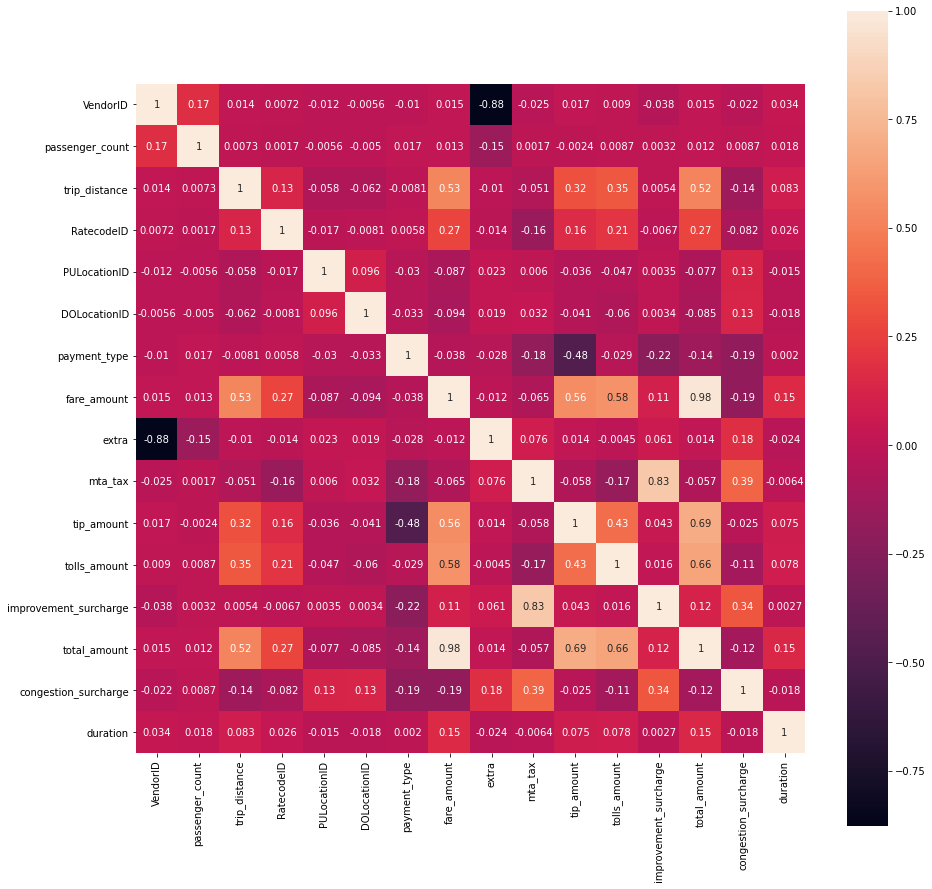

In [233]:
plt.figure(figsize=(15,15))
sns.heatmap(df.corr(), annot=True,square=True)

Теперь же можем увидеть, что стоимость поездки коррелирует с расстоянием, но при этом без ограничения наших данных такая зависимость была вовсе неочевидна, помимо этого незначительную корреляцию видим с типом платежа, остальные же данные всё еще вносят довольно слабый вклад в нашу стоимость.

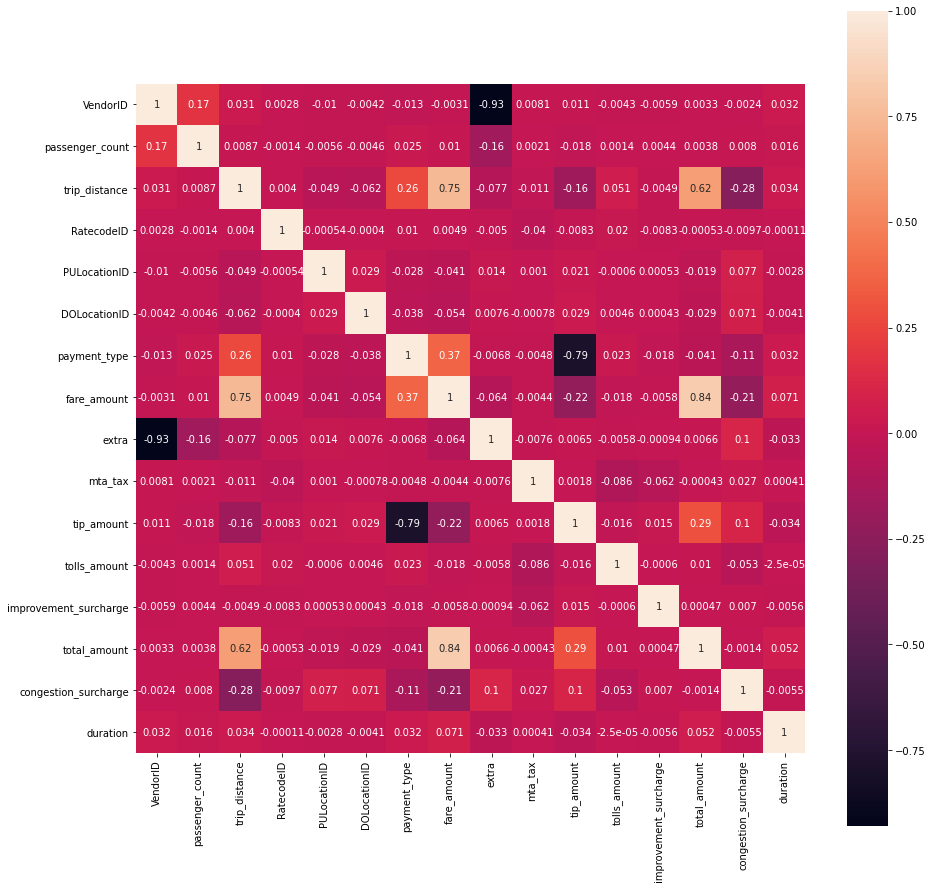

In [234]:
q25 = df.total_amount.quantile(0.25)
q75 = df.total_amount.quantile(0.75)
q25_75 = df[(df['total_amount'] > q25) & (df['total_amount'] < q75)]

plt.figure(figsize=(15,15))
sns.heatmap(q25_75.corr(), annot=True,square=True);

In [235]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
count,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07,1.304733e+07
mean,1.669905e+00,1.536483e+00,2.929978e+00,1.046939e+00,1.644688e+02,1.622425e+02,1.282633e+00,1.280497e+01,1.103090e+00,4.950811e-01,2.229061e+00,3.530412e-01,2.982746e-01,1.883133e+01,2.312336e+00,1.035407e+03
std,4.702471e-01,1.166086e+00,6.537897e+00,6.314736e-01,6.560215e+01,6.993714e+01,4.771249e-01,1.178924e+01,1.251067e+00,6.215554e-02,2.752146e+00,1.706754e+00,3.167999e-02,1.455624e+01,6.800590e-01,4.043300e+03
min,1.000000e+00,0.000000e+00,1.000000e-02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-2.700000e+01,-5.000000e-01,-2.008000e+02,-4.050000e+01,-3.000000e-01,-1.472800e+03,-2.500000e+00,1.000000e+00
25%,1.000000e+00,1.000000e+00,9.800000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00,3.980000e+02
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.000000e+00,5.000000e-01,5.000000e-01,1.960000e+00,0.000000e+00,3.000000e-01,1.475000e+01,2.500000e+00,6.630000e+02
75%,2.000000e+00,2.000000e+00,2.970000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,2.500000e+00,5.000000e-01,2.960000e+00,0.000000e+00,3.000000e-01,2.030000e+01,2.500000e+00,1.080000e+03
max,2.000000e+00,9.000000e+00,1.913018e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,6.012500e+03,1.130100e+02,3.080000e+01,1.100000e+03,9.105000e+02,3.000000e-01,6.015800e+03,3.000000e+00,5.115070e+05


Пройдено аномальное расстояние (21000 миль), при этом довольно низкая стоимость, скорее всего это какая-то ошибка в данных

In [236]:
df[df['trip_distance'] == df['trip_distance'].max()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
704581,2.0,2019-12-04 10:20:13,2019-12-04 10:24:43,1.0,19130.18,5.0,N,224,224,2.0,11.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,270.0


В этих данных отрицательная стоимость (возможно это те случаи, когда клиент заплатил за поездку, но потом решил её отменить и ему вернули деньги)

In [237]:
df[df['total_amount'] < 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
708,2.0,2019-12-01 00:07:31,2019-12-01 00:24:55,1.0,5.76,1.0,N,163,116,4.0,-20.0,-0.5,-0.5,0.0,0.0,-0.3,-23.8,-2.5,1044.0
1108,2.0,2019-12-01 00:01:55,2019-12-01 00:03:52,5.0,0.18,1.0,N,65,65,3.0,-3.5,-0.5,-0.5,0.0,0.0,-0.3,-4.8,0.0,117.0
1309,2.0,2019-12-01 00:09:47,2019-12-01 00:26:51,1.0,3.93,1.0,N,229,7,4.0,-15.5,-0.5,-0.5,0.0,0.0,-0.3,-19.3,-2.5,1024.0
1688,2.0,2019-12-01 00:54:27,2019-12-01 00:56:10,1.0,0.78,1.0,N,90,100,3.0,-4.0,-0.5,-0.5,0.0,0.0,-0.3,-7.8,-2.5,103.0
1766,2.0,2019-12-01 00:40:46,2019-12-01 00:48:19,1.0,2.21,1.0,N,263,233,4.0,-8.5,-0.5,-0.5,0.0,0.0,-0.3,-12.3,-2.5,453.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13234129,2.0,2020-01-31 23:24:40,2020-01-31 23:50:34,3.0,4.49,1.0,N,148,48,2.0,-19.5,-0.5,-0.5,0.0,0.0,-0.3,-23.3,-2.5,1554.0
13234388,2.0,2020-01-31 23:52:53,2020-02-01 00:22:09,1.0,7.28,1.0,N,229,36,4.0,-25.5,-0.5,-0.5,0.0,0.0,-0.3,-29.3,-2.5,1756.0
13234486,2.0,2020-01-31 23:25:44,2020-01-31 23:29:59,1.0,0.96,1.0,N,48,186,4.0,-5.0,-0.5,-0.5,0.0,0.0,-0.3,-8.8,-2.5,255.0
13235211,2.0,2020-01-31 23:30:03,2020-01-31 23:38:09,1.0,0.84,1.0,N,48,186,3.0,-6.5,-0.5,-0.5,0.0,0.0,-0.3,-10.3,-2.5,486.0


Можно ещё посмотреть на самую низкую и высокую стоимость поездок (-1472 и 398471 долларов)

In [238]:
df[df['total_amount'] == df['total_amount'].max()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
513922,1.0,2019-12-03 15:00:58,2019-12-03 15:18:04,1.0,0.2,1.0,N,238,141,2.0,6012.5,2.5,0.5,0.0,0.0,0.3,6015.8,2.5,1026.0


In [239]:
df[df['total_amount'] == df['total_amount'].min()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration
4274511,2.0,2019-12-18 12:48:52,2019-12-20 13:34:47,2.0,1.62,1.0,N,193,193,3.0,-1472.0,0.0,-0.5,0.0,0.0,-0.3,-1472.8,0.0,175555.0


Сразу отрежем по 1 проценту с обеих сторон наших данных, чтоб получить воспроизводимый график, иначе из-за очень больших выбросов не получится ничего разглядеть. У нас получился довольно ассиметричный график, соответственно его очень сложно охарактеризовать как график с нормальным распределением, убедимся в этом, использовав тест д'Агостино

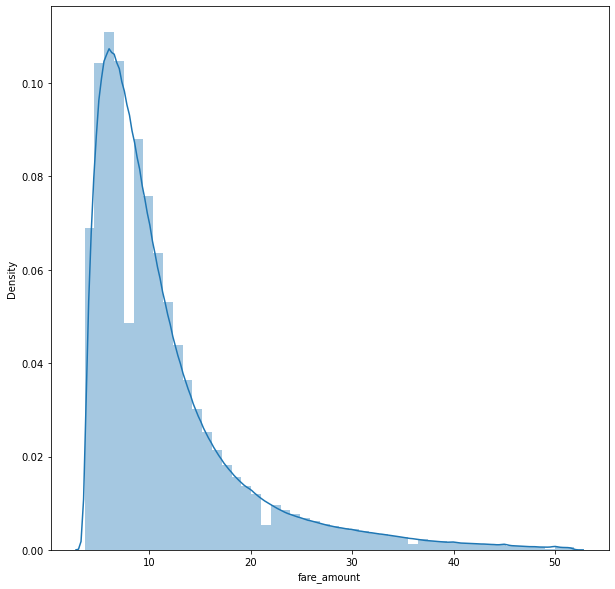

In [240]:
q01 = df.fare_amount.quantile(0.01)
q99 = df.fare_amount.quantile(0.99)
q01_99 = df[(df['fare_amount'] > q01) & (df['fare_amount'] < q99)]

plt.figure(figsize=(10,10))
sns_plot = sns.distplot(q01_99['fare_amount'])
fig = sns_plot.get_figure()

H0: наши данные имеют нормальное распределение

H1: наши данные не имеют нормального распределения

получаем pvalue приближенно равное 0 (что значительно ниже потенциальных 0.05, 0.03, 0.01 и т.д.), поэтому отклоняем нулевую гипотезу

Видимо очень много людей заказывает такси на небольшое расстояние, но при этом после самого популярного расстояния спрос на более и более длинные поездки спадает довольно медленно (ещё можно обратить внимание на довольно существенный спад после пика и такой же существенный подъём)

In [241]:
normaltest(q01_99.fare_amount)

NormaltestResult(statistic=5091668.01637926, pvalue=0.0)

Подготовим наши данные для обучения, в качестве модели выберем XGBoost

In [246]:
X = q01_99.drop(['total_amount', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag',
                 'tip_amount', 'tolls_amount', 'fare_amount'], axis=1)
y = q01_99['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=17)

In [247]:
%%time
xg = XGBRegressor(max_depth=5, reg_lambda=0.4, random_state=17)
xg.fit(X_train, y_train);

CPU times: user 1h 2min 52s, sys: 1min 1s, total: 1h 3min 53s
Wall time: 22min 38s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=17,
             reg_alpha=0, reg_lambda=0.4, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [248]:
print("Mean absolute error (train): %.3f" % mean_absolute_error(y_train, xg.predict(X_train)))
print("Mean absolute error (test): %.3f" % mean_absolute_error(y_test, xg.predict(X_test)))

Mean absolute error (train): 0.367
Mean absolute error (test): 0.367


Если в какой-то промежуток были скидки, это значит, что наша модель должна больше ошибаться в этот отрезок времени, поэтому попробуем отдельно посчитать среднюю ошибку для каждого дня на тестовых данных

In [249]:
df_test_days = df.loc[X_test.index]
df_test_days['predict'] = xg.predict(X_test)
df_test_days = df_test_days.sort_values(by=['tpep_pickup_datetime'])
df_test_days['year'] = df_test_days['tpep_pickup_datetime'].dt.year
df_test_days['day'] = df_test_days['tpep_pickup_datetime'].dt.day

december = df_test_days[df_test_days['year'] == 2019]
january = df_test_days[df_test_days['year'] == 2020]

In [250]:
december_dict = {}
january_dict = {}
for day in range(1, 32):
    df_dec = december[december['day'] == day]
    df_jan = january[january['day'] == day]
    december_dict[day] = mean_absolute_error(df_dec['fare_amount'], df_dec['predict'])
    january_dict[day] = mean_absolute_error(df_jan['fare_amount'], df_jan['predict'])

Видим, что максимальное отклонение от среднего не сильно велико, поэтому у нас недостаточно оснований для того, чтобы утверждать о наличии скидок или акций

In [251]:
max(december_dict.values())

0.442666819401566

In [252]:
max(january_dict.values())

0.4129801108497404